<a href="https://colab.research.google.com/github/Wesley00s/Computer-Vision/blob/main/Wesley_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install git+https://github.com/qubvel/segmentation_models --q

  Preparing metadata (setup.py) ... done


In [ ]:
!pip install opendatasets --q

In [ ]:
!pip install tensorflow==2.10 --q

In [ ]:
import numpy as np
import pandas as pd

import os
import pathlib
import glob
import opendatasets as od

import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import ZeroPadding2D
import keras
from keras.utils import img_to_array, load_img

import segmentation_models as sm
sm.set_framework('keras')

from segmentation_models import Unet
from segmentation_models import get_preprocessing
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


Segmentation Models: using `keras` framework.


In [ ]:
od.download('https://www.kaggle.com/datasets/humansintheloop/plant-semantic-segmentation')

Skipping, found downloaded files in "./plant-semantic-segmentation" (use force=True to force download)


In [ ]:
caminho_raiz = '/content/plant-semantic-segmentation/Plant segmentation'
data_dir = pathlib.Path(caminho_raiz)
subpastas = [pasta for pasta in data_dir.iterdir() if pasta.is_dir()]

In [ ]:
print(f"Subpastas: {subpastas}")

Subpastas: [PosixPath('/content/plant-semantic-segmentation/Plant segmentation/images'), PosixPath('/content/plant-semantic-segmentation/Plant segmentation/masks')]


In [ ]:
cam_images = list(subpastas[1].iterdir())
cam_masks= list(subpastas[0].iterdir())

In [ ]:
cam_images = sorted(cam_images)
cam_masks = sorted(cam_masks)

In [ ]:
print(f"Imagem original: {cam_images[10:13]}")
print(f"Máscara imagem: {cam_masks[10:13]}")

Imagem original: [PosixPath('/content/plant-semantic-segmentation/Plant segmentation/masks/T02_Box007_2017-09-13T06-44-53-948.png'), PosixPath('/content/plant-semantic-segmentation/Plant segmentation/masks/T02_Box007_2017-09-14T08-17-35-120.png'), PosixPath('/content/plant-semantic-segmentation/Plant segmentation/masks/T02_Box007_2017-09-18T08-52-54-989.png')]
Máscara imagem: [PosixPath('/content/plant-semantic-segmentation/Plant segmentation/images/T02_Box007_2017-09-13T06-44-53-948.png'), PosixPath('/content/plant-semantic-segmentation/Plant segmentation/images/T02_Box007_2017-09-14T08-17-35-120.png'), PosixPath('/content/plant-semantic-segmentation/Plant segmentation/images/T02_Box007_2017-09-18T08-52-54-989.png')]


In [ ]:
print(f"Total de imagens de treino: {len(cam_images)} | Toral de máscaras de treino: {len(cam_masks)}")

Total de imagens de treino: 144 | Toral de máscaras de treino: 144


# Visualização

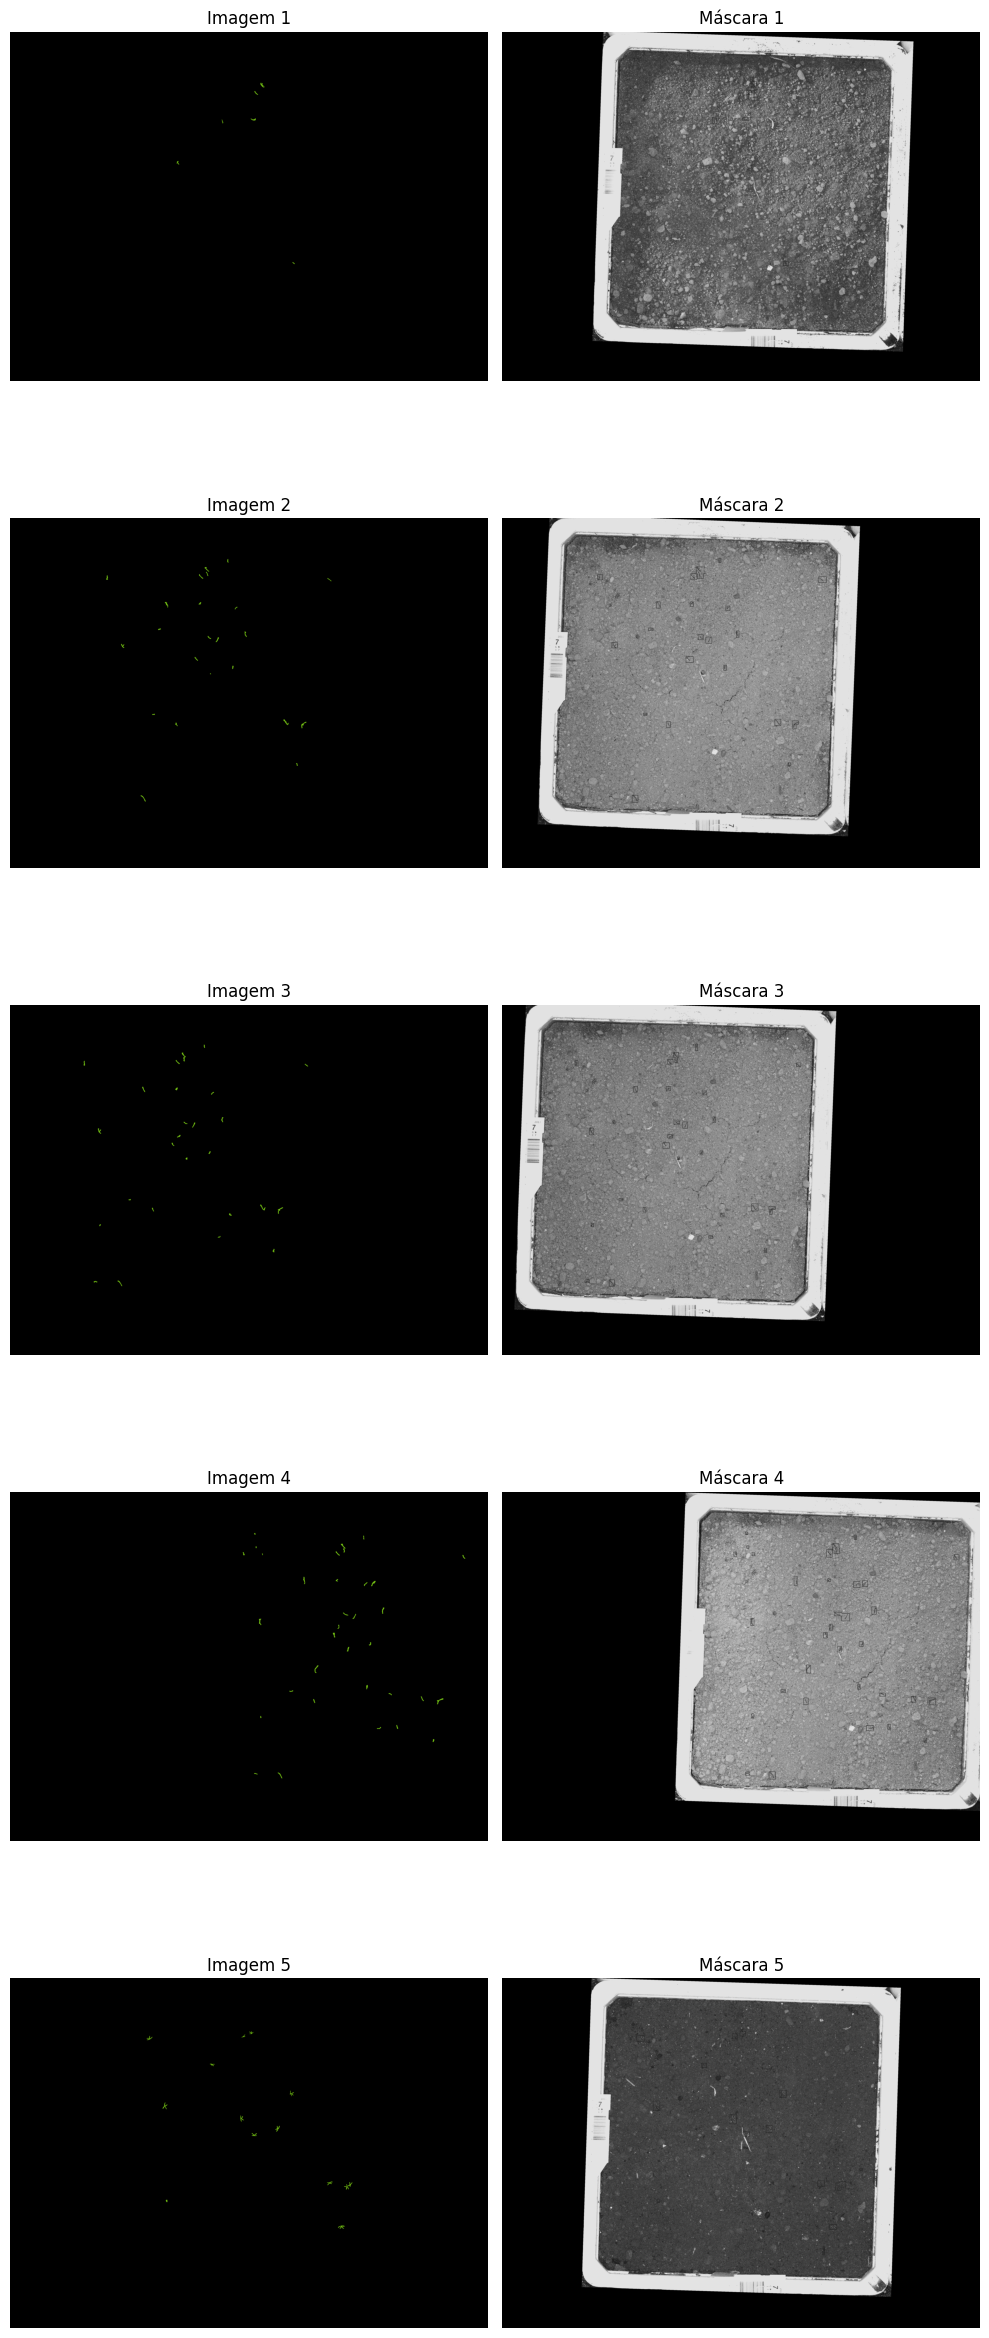

In [ ]:
num_imgs = 5
fig, axs = plt.subplots(num_imgs, 2, figsize=(10, 5 * num_imgs))

for i in range(num_imgs):
    img = cv2.imread(str(cam_images[i]))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(str(cam_masks[i]), cv2.IMREAD_GRAYSCALE)

    axs[i, 0].imshow(img)
    axs[i, 0].set_title(f"Imagem {i+1}")
    axs[i, 0].axis('off')

    axs[i, 1].imshow(mask, cmap="gray")
    axs[i, 1].set_title(f"Máscara {i+1}")
    axs[i, 1].axis('off')

plt.tight_layout()
plt.show()

# Pré-processamento


In [ ]:
height = 256
width = 256
channels = 3

In [ ]:
imagens =  []
mascaras = []

count_img = 0
count_mask = 0

img_size = (width, height)

for caminho in cam_images:
  img = cv2.imread(str(caminho))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img, img_size)
  imagens.append(img)
  count_img += 1

for caminho in cam_masks:
  mask = cv2.imread(str(caminho), cv2.IMREAD_GRAYSCALE)
  mask = cv2.resize(mask, img_size)
  mascaras.append(mask)
  count_mask += 1

X = np.array(imagens, dtype=np.float32)
Y = np.array(mascaras, dtype=np.float32)
Y = np.expand_dims(Y, axis=-1)
Y /= 255.0

print(f'Imagens_train: {count_img} | Máscaras_train: {count_mask}')

Imagens_train: 144 | Máscaras_train: 144


In [ ]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

In [ ]:
Y_train.shape

(115, 256, 256, 1)

# U-NET

In [ ]:
BACKBONE = 'resnet34'
preprocess_input = get_preprocessing(BACKBONE)

In [ ]:
X_train = preprocess_input(X_train)
X_val = preprocess_input(X_val)

In [ ]:
model = Unet(
    backbone_name=BACKBONE,
    classes=1,
    activation='sigmoid',
    encoder_weights='imagenet',
    input_shape=(height, width, channels),
)
model.compile(
    'Adam',
    loss=bce_jaccard_loss,
    metrics=[iou_score],
)

In [ ]:
hist = model.fit(
    X_train,
    Y_train,
    batch_size=16,
    epochs=3,
    validation_data=(X_val, Y_val),
)

Epoch 1/3
8/8 [==============================] - 209s 25s/step - loss: 1.3475 - iou_score: 0.2077 - val_loss: 4.2537 - val_iou_score: 0.2589
Epoch 2/3
8/8 [==============================] - 194s 24s/step - loss: 1.2139 - iou_score: 0.2670 - val_loss: 1.8796 - val_iou_score: 0.1102
Epoch 3/3
8/8 [==============================] - 209s 26s/step - loss: 1.1590 - iou_score: 0.2912 - val_loss: 5.8401 - val_iou_score: 0.2505
